In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import urllib.request
import pandas as pd
from PIL import Image
from datetime import date

## 1) El ciclo de actividad solar
Descargue el historial de avistamientos de manchas solares de la AAVSO: https://ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/american/lists/list_aavso-arssn_daily.txt
Este es un archivo con año, mes, día y número de manchas solares en ese día. Se recomienda usar la función pd.to_datetime para graficar con las fechas.
Inlcuya en su análisis solamente los datos hasta el 1 de enero de 2012.

In [37]:
url = 'https://ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/american/lists/list_aavso-arssn_daily.txt'

try:
    datos1 = urllib.request.urlopen(url).read().decode("utf-8")
    data = [linea.split() for linea in datos1.splitlines()[1:]]  # Salta la primera fila
    df = pd.DataFrame(data, columns=['Year', 'Month', 'Day', 'SSN'])
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert columns to numeric
    df['Fecha'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.drop(['Year', 'Month', 'Day'], axis=1)
    df = df[['Fecha', 'SSN']]
    df = df.loc[df['Fecha'] <= '2012-01-01']
    print(df)
except Exception as e:
    print(f"Error reading or parsing data: {e}")


           Fecha   SSN
1     1945-01-01  10.0
2     1945-01-02   0.0
3     1945-01-03   1.0
4     1945-01-04   2.0
5     1945-01-05  11.0
...          ...   ...
24468 2011-12-28  62.0
24469 2011-12-29  67.0
24470 2011-12-30  58.0
24471 2011-12-31  55.0
24472 2012-01-01  39.0

[24472 rows x 2 columns]


In [31]:
#df['fecha'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#df = df.drop(['Year', 'Month', 'Day'], axis=1)

In [32]:
#print(df)

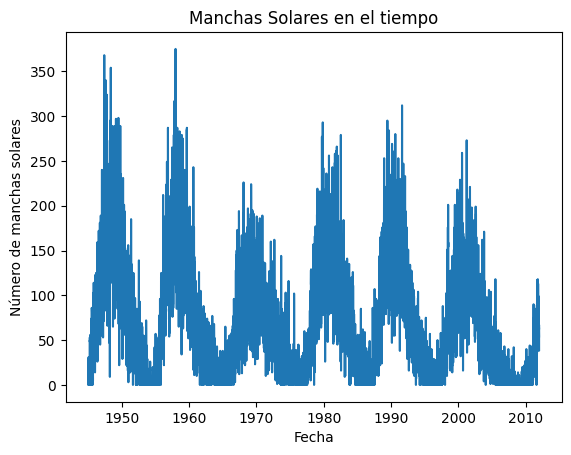

In [38]:
#df.set_index('Fecha', inplace=True)
plt.plot(df['Fecha'],df['SSN'])
plt.xlabel('Fecha')
plt.ylabel('Número de manchas solares')
plt.title('Manchas Solares en el tiempo')
plt.show()

1.1) Período del ciclo solar
Con una transformada discreta de Fourier (np.fft.fft) identifique la frecuencia principal de la señal 𝑓𝑝. Esto corresponde al período del ciclo de actividad solar 𝑃 = 1/𝑓𝑝. Dé este período en años.

In [39]:
#Transformo las manchas y hallo la frecuencia principal
fft_manchas = (np.fft.fft(df['SSN']))
frecuencias = np.fft.fftfreq(len(df['SSN']), d=1)  

indice_fp = (np.argmax(fft_manchas[1:]))+1
fp = abs(frecuencias[indice_fp])
periodo_dias = 1 / fp 
periodo_anos = periodo_dias / 365 
print(f"La frecuencia principal de la señal es = {fp} (1/días)")
print(f"El período del ciclo solar es = {periodo_dias} días o = {periodo_anos:.2f} años.")

La frecuencia principal de la señal es = 0.0002451781627983001 (1/días)
El período del ciclo solar es = 4078.6666666666665 días o = 11.17 años.


1.2) Reducción de ruido: filtro pasabajas
Aplique un filtro pasabajas a la señal para quitarle el ruido, y observar la tendencia principal de la señal.
La idea es multiplicar la transformada por una función:
señal filtrada = IFFT(señal original × filtro(𝑓))
donde 𝑓 es la frecuencia, que puede sacar usando np.fft.fftfreq(n), con n la longitud de sus datos.
Para que sea un filtro pasabajas, la función filtro(𝑓) tiene que ser decreciente. Algunas ideas son:
filtro(𝑓, 𝛼) = exp(−(𝑓𝛼)2) (tipo Gauss)
filtro(𝑓, 𝑓limit) = 1 if |𝑓| < 𝑓limit else 0 (tipo threshold)
Se recomienda un 𝛼 grande (≈ 1000) y un 𝑓limit pequeño (≈ 0.001). Trate de buscar el filtro pasabajas
que más ruido quite de la señal, pero tal que no se pierda demasiada información del fenómeno físico.

In [40]:
#Aplico funcion de ventana de Hamming
alfa = 0.001
filtro = np.exp(-(frecuencias / alfa )**2)
fft_manchas_filtrada = filtro * fft_manchas

#### 1.2.a)
Grafique la transformada (log10|Transformada| vs log10|frecuencia|) y la transformada filtrada.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10408\4251249251.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(frecuencias)), np.log10(np.abs(fft_manchas)), label='Transformada original')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10408\4251249251.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(frecuencias)), np.log10(np.abs(fft_manchas_filtrada)), label='Transformada filtrada', linestyle='--')


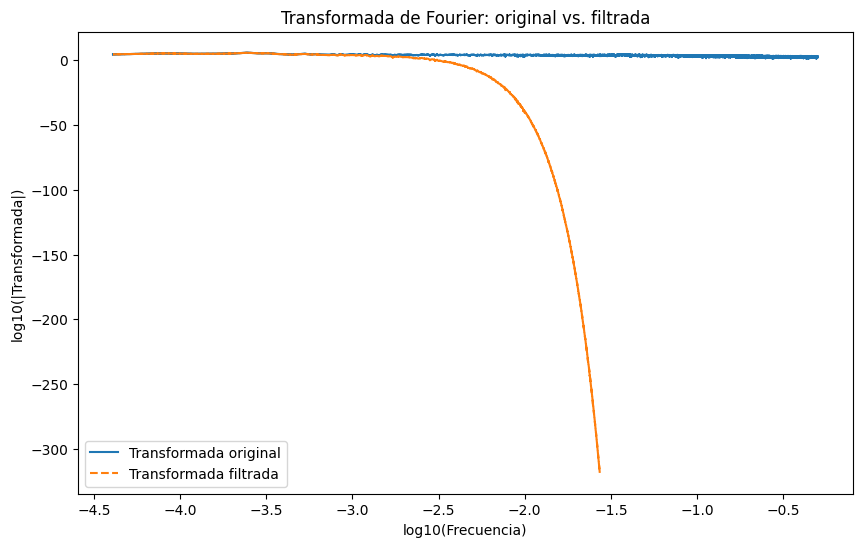

In [41]:
#Gráfica de t(log10 Transformada| vs log10|frecuencia| para la transformada original y filtrada
plt.figure(figsize=(10, 6))
plt.plot(np.log10(np.abs(frecuencias)), np.log10(np.abs(fft_manchas)), label='Transformada original')
plt.plot(np.log10(np.abs(frecuencias)), np.log10(np.abs(fft_manchas_filtrada)), label='Transformada filtrada', linestyle='--')
plt.xlabel('log10(Frecuencia)')
plt.ylabel('log10(|Transformada|)')
plt.legend()
plt.title('Transformada de Fourier: original vs. filtrada')
plt.show()

#### 1.2.b)
Transforme de vuelta al dominio de tiempo con np.fft.ifft, y quédese sólo con la parte real de la
función.
Grafique la señal original y la señal filtrada.

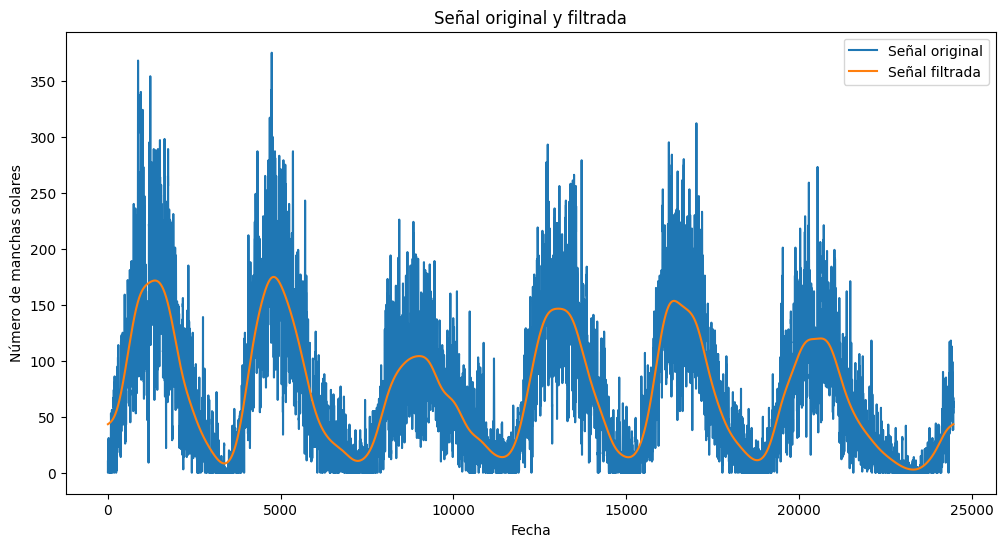

In [42]:
#Transformada inversa para recuperar la señal filtrada
manchas_filtrada = (np.fft.ifft(fft_manchas_filtrada)).real

#Graficar la señal original y la señal filtrada
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SSN'], label='Señal original')
plt.plot(df.index, manchas_filtrada, label='Señal filtrada')
plt.xlabel('Fecha')
plt.ylabel('Número de manchas solares')
plt.title('Señal original y filtrada')
plt.legend()
plt.show()

1.3) Extrapolación de funciones (más o menos) periódicas
• Use los primeros 𝑛 = 10 armónicos de la señal para predecir en qué parte del ciclo solar estamos
ahora en Agosto de 2024.
‣ Las 𝑛 frecuencias más bajas, en el arreglo que devuelve np.fft.fftfreq, están en los primeros 𝑛
y los últimos 𝑛 elementos.
‣ Debe construir un nuevo array con estas frecuencias 𝑓𝑘 y con los valores de la transformada en
esas frecuencias 𝐹𝑘, que serán de longitud 2𝑛.
• Para extrapolar la señal, primero cree un array de tiempos que cuente los días desde que empiezan
los datos hasta una fecha de su elección en el futuro, por ejemplo 1 de Enero de 2045.
‣ Consejo: use datetime.date y reste las dos fechas para averiguar cuántos días necesita. También
puede hacer uso de pd.date_range.
• Luego, use la definición general de la transformada inversa para conseguir la señal extrapolada:
𝑦(𝑡𝑗) = ℱ−1{𝐹 , 𝑓}(𝑡𝑗) =
1
𝑁
Σ 2
𝑛
𝑘=1
𝐹𝑘𝑒2𝜋𝑖𝑡𝑗𝑓𝑘
Donde 𝑁 es la longitud original de los datos (esto se hace por cómo está implementado np.fft.fft,
que fue de donde sacamos la transformada 𝐹 .)
Responda:
1. ¿En qué parte del ciclo solar estamos?
2. ¿Cuántas manchas deberíamos esperar a mitad de Agosto?
Compare sus predicciones con http://solarcyclescience.com/forecasts.html

In [44]:
df.set_index('Fecha', inplace=True)

In [50]:
n = 10
frecuencias_seleccionadas = np.concatenate((frecuencias[:n], frecuencias[-n:]))
F_seleccionadas = np.concatenate((fft_manchas[:n], fft_manchas[-n:]))

# Crear un array de tiempos que cuente los días desde que empiezan los df hasta una fecha en el futuro
fecha_final = date(2045, 1, 1)
fecha_inicial = df.index[0].date()
dias = (fecha_final - fecha_inicial).days
tiempos = np.arange(len(df), len(df) + dias)

# Extrapolación de la señaligena utilizando la transformada inversa de Fourier
N = len(df)
y_extrapolada = np.zeros(len(tiempos))
for j, t in enumerate(tiempos):
    y_extrapolada[j] = np.sum(F_seleccionadas * np.exp(2 * np.pi * 1j * t * frecuencias_seleccionadas)) / N
#Vemos agosto_2024
indice_agosto_2024 = (pd.Timestamp('2024-08-15') - df.index[-1]).days
señal_agosto_2024 = round(y_extrapolada.real[indice_agosto_2024], 3)

print("En agosto de 2024 estamos en la fase ascendente del ciclo solar, llegando al pico.")
print(f"Para la mitad de agosto de 2024 deberíamos esperar aproximadamente {señal_agosto_2024} manchas solares.")

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10408\2558213030.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  y_extrapolada[j] = np.sum(F_seleccionadas * np.exp(2 * np.pi * 1j * t * frecuencias_seleccionadas)) / N


En agosto de 2024 estamos en la fase ascendente del ciclo solar, llegando al pico.
Para la mitad de agosto de 2024 deberíamos esperar aproximadamente 161.549 manchas solares.


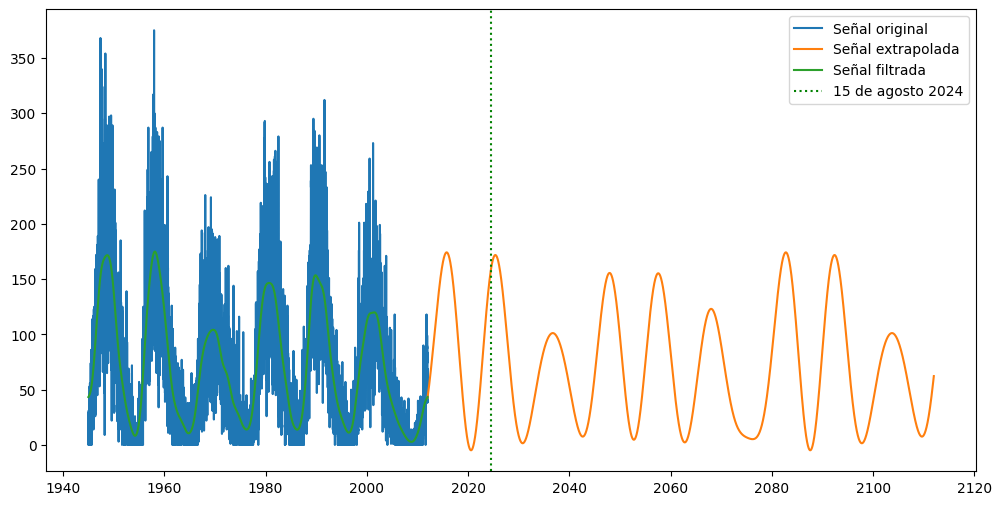

In [51]:
# Graficar la señaligena original y la extrapolada
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SSN'], label='Señal original')
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=len(y_extrapolada)), y_extrapolada.real, label='Señal extrapolada')
plt.plot(df.index, manchas_filtrada, label='Señal filtrada')
plt.axvline(pd.to_datetime("2024-08-15"), color='Green', linestyle=':', label='15 de agosto 2024')
plt.legend()
plt.show()

### 2) Transformada 2D
Descargue la imagen de prueba: https://commons.wikimedia.org/wiki/File:Noisy_Smithsonian_Castle.
jpg.
Para abrir la imagen puede usar la librería PIL, (pip install pillow) que permite leer imágenes
como arrays de la siguiente manera:
from PIL import Image
import numpy as np
img = np.array(Image.open("image.jpg")).astype(float)
Grafique la imagen usando la función imshow de matplotlib. Se recomienda usar cmap='gray'.

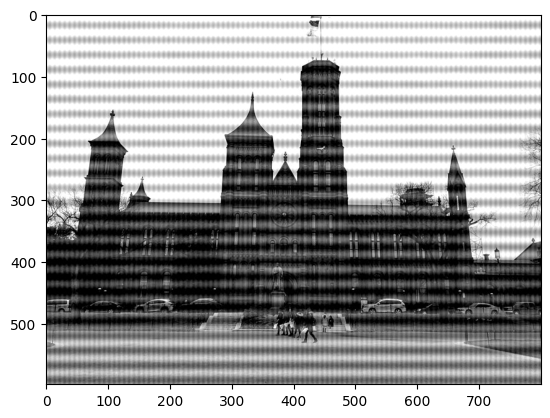

In [15]:
img = np.array(Image.open("Noisy_Smithsonian_Castle.jpg")).astype(float)
plt.imshow(img, cmap='gray')

2.1)
Grafique la transformada de Fourier bidimensional con np.fft.fft2. Use np.fft.fftshift para centrar
el componente de frecuencia cero. Use una escala de color logarítmica para poder observar los
detalles.

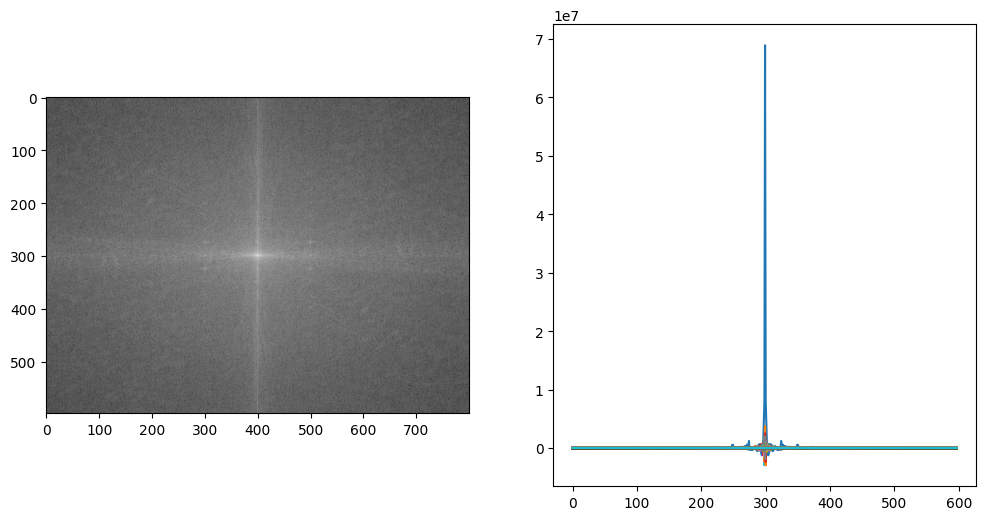

In [20]:
#Calculo la transformada 
fourier_img = np.fft.fft2(img)

#Centro el componente de frecuencia cero
F = np.fft.fftshift(fourier_img)

#Grafico la transformada con escala logarítmica
Fi= np.log(np.abs(F)+1) 

#Grafica

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot la primer figura
axs[0].imshow(Fi, cmap='gray')

# Plot la segunda figura
axs[1].plot(F)

# Muestra el plot
plt.show()

2.2)
El ruido periódico de la imagen se representa en los puntos brillantes de la transformada (exceptuando
el centro). Por ejemplo, las barras horizontales en la imagen se ven como una línea horizontal en la
imagen del a transformada.
Identifique los índices i,j donde están estos puntos brillantes, y elimínelos mandando secciones del
array de la transformada a cero:
F[j:j+10,i:i+10] = 0.
Muestre la imagen sin el ruido periódico, usando la transformada inversa np.fft.ifft.
Puntos extra entre más ruido periódico sea capaz de remover.

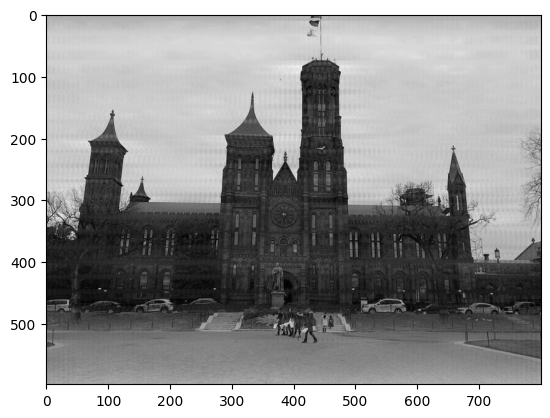

In [21]:
#Borro las 2 líneas externas
posiciones_i = [300,500]  
for i in posiciones_i:
    for j in range(0, 598):
      F[j:j+10, i:i+5] = 0
      
#Borro la línea interna excepto el centro
posiciones_i = [400]  
for i in posiciones_i:
    for j in range(0, 285):
      F[j:j+10, i:i+5] = 0
    for j in range(305, 598):
      F[j:j+10, i:i+5] = 0
      

filtered_img = np.fft.ifft2(np.fft.ifftshift(F))

#Grafico la imagen filtrada
plt.imshow(np.abs(filtered_img), cmap='gray')